In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sample_submission_path = './sample_submission.csv'
data_path = './train.csv'
val_path = './test.csv'



In [2]:
# 读取数据
sample_submission = pd.read_csv(sample_submission_path,sep=',')
Data = pd.read_csv(data_path,sep=',')
val = pd.read_csv(val_path,sep=',')
 

In [3]:
# 获取简单描述
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
# 通过describe()方法可以显示数值属性的摘要。
# count、mean、min以及max行的意思很清楚。需要注意的是，这里的空值会被忽略
# 百分位数表示一组观测值中给 定百分比的观测值都低于该值。
Data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


array([[<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'RoomService'}>],
       [<AxesSubplot: title={'center': 'FoodCourt'}>,
        <AxesSubplot: title={'center': 'ShoppingMall'}>],
       [<AxesSubplot: title={'center': 'Spa'}>,
        <AxesSubplot: title={'center': 'VRDeck'}>]], dtype=object)

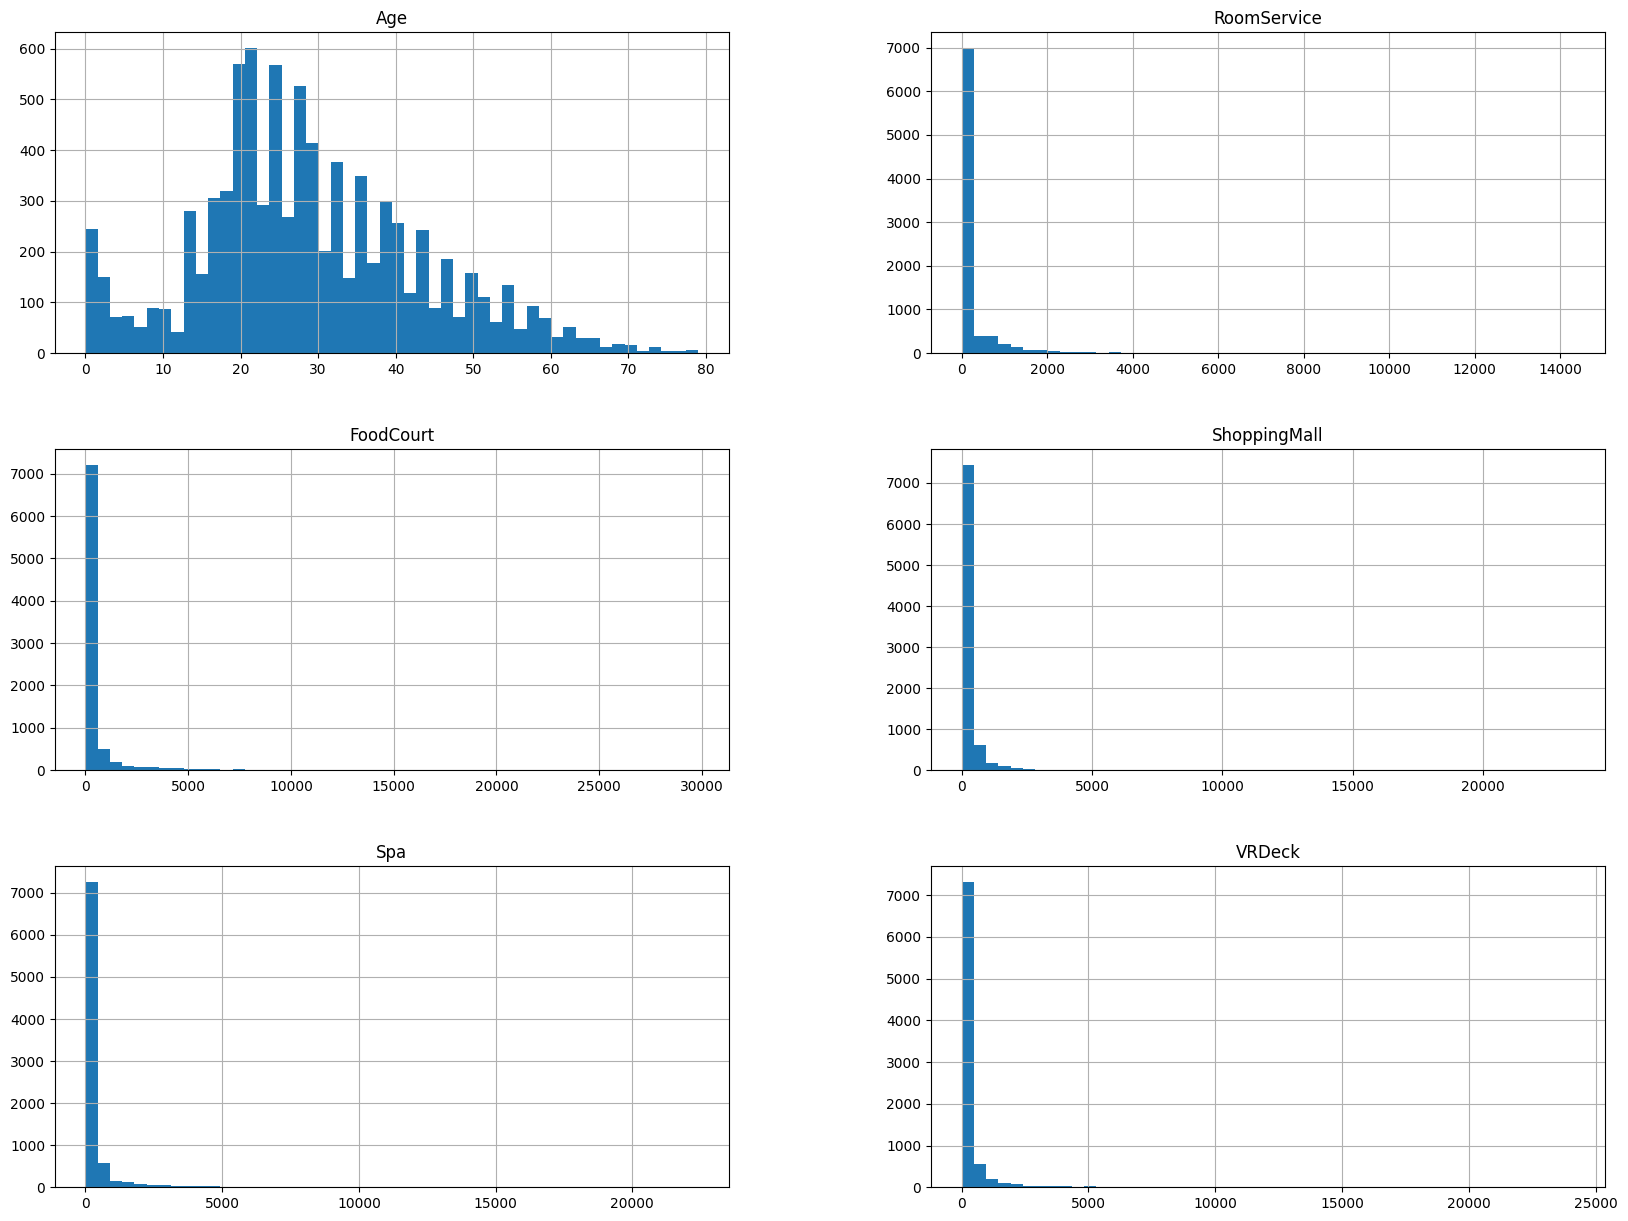

In [5]:
# 通过matplotlib画出pd数据的直方图

Data.hist(bins=50, figsize=(20,15))

In [25]:
Data.isnull().any()

PassengerId     False
HomePlanet       True
CryoSleep        True
Cabin            True
Destination      True
Age             False
VIP              True
RoomService      True
FoodCourt        True
ShoppingMall     True
Spa              True
VRDeck           True
Name             True
Transported     False
class_Age        True
dtype: bool

In [7]:
median = Data["Age"].median()  # option 3
Data["Age"].fillna(median, inplace=True)


<AxesSubplot: >

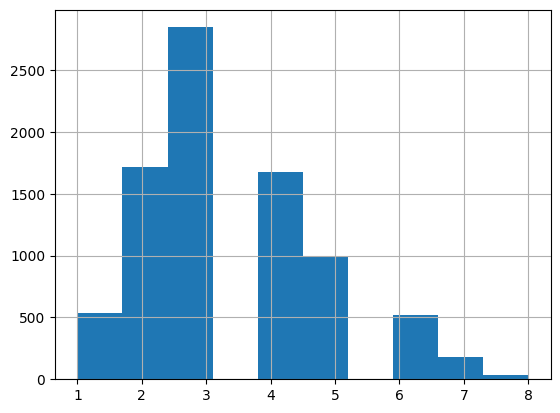

In [24]:
# 创建一个自定理的新类

Data['class_Age'] = pd.cut(Data['Age'],bins=[i*10 for i in range(11)],labels =[i for i in range(1,11)] )

Data['class_Age'].hist()


In [26]:
Data['Age']

0       39.0
1       24.0
2       58.0
3       33.0
4       16.0
        ... 
8688    41.0
8689    18.0
8690    26.0
8691    32.0
8692    44.0
Name: Age, Length: 8693, dtype: float64

In [27]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(Data, test_size=0.2,random_state=42)

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(test_size=0.2)
for train_index, test_index in split.split(Data, Data['Age']): # 需要x，y，y作为																																		标签使用，这样就可以通过y来分层
    train = Data.loc[train_index]
    test = Data.loc[test_index]


In [65]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit  # 引入的库可以进行分层抽样
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


cat_list = ['HomePlanet','CryoSleep' ,'Destination' ,'VIP' ]
num_list = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Age']

num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy="median")),
            ('std_scaler', StandardScaler()),
])
    
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
])

full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_list),
            ("cat",cat_pipeline, cat_list),
])

target = full_pipeline.fit_transform(train[num_list+cat_list])
test_target = full_pipeline.transform(test[num_list+cat_list])
val_target =  full_pipeline.transform(val[num_list+cat_list])


In [66]:
target_label = np.array(train['Transported']*1.0)
test_label = np.array(test['Transported']*1.0)

In [67]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

random_forest_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=1000, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier( max_iter=100,random_state=42)
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf",mlp_clf),
]
voting_clf = VotingClassifier(named_estimators)



voting_clf.fit(target, target_label )


/Users/hzh/miniforge3/envs/tfpy39/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(n_estimators=1000,
                                                     random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(n_estimators=1000,
                                                   random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf',
                              MLPClassifier(max_iter=100, random_state=42))])

In [68]:
predictions =  voting_clf.predict(test_target)
predictions

array([1., 0., 1., ..., 1., 0., 1.])

In [69]:
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.metrics import accuracy_score
scores = cross_val_score(voting_clf  ,test_target[:,:-1] , test_label.reshape(test_label.shape[0]) ,cv=10)
score = scores.mean()
print('score ', score )


accuracy_score = accuracy_score(test_label, predictions, normalize=True, sample_weight=None)
print('accuracy_score',accuracy_score)

/Users/hzh/miniforge3/envs/tfpy39/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hzh/miniforge3/envs/tfpy39/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hzh/miniforge3/envs/tfpy39/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hzh/miniforge3/envs/tfpy39/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.wa

score  0.7636901202577902
accuracy_score 0.7855089131684876


/Users/hzh/miniforge3/envs/tfpy39/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
predictions =  voting_clf.predict(val_target)

In [22]:
target.shape

(6954, 16)

In [23]:
predictions 

array([1., 0., 1., ..., 1., 1., 0.])